https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

https://www.youtube.com/watch?v=tepxdcepTbY

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

/home/sjhyeon/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [6]:
df = pd.read_csv('GE.csv')

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-05-11,0.694862,0.703626,0.694862,0.694862,0.145606,2505984
1,1970-05-12,0.692358,0.692358,0.681090,0.686098,0.143769,3065088
2,1970-05-13,0.684846,0.684846,0.666066,0.666066,0.139571,2885376
3,1970-05-14,0.666066,0.666066,0.648538,0.657302,0.137735,5211648
4,1970-05-15,0.657302,0.669822,0.647286,0.667318,0.139834,4852224


In [8]:
train_dates = pd.to_datetime(df['Date'])
cols = list(df)[1:6]

df_for_training = df[cols].astype(float)

In [9]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [10]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


In [11]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (12851, 14, 5).
trainY shape == (12851, 1).


In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/10
723/723 [==============================] - 6s 7ms/step - loss: 0.0909 - val_loss: 0.0037
Epoch 2/10
723/723 [==============================] - 5s 7ms/step - loss: 0.0317 - val_loss: 0.0046
Epoch 3/10
723/723 [==============================] - 5s 7ms/step - loss: 0.0304 - val_loss: 0.0025
Epoch 4/10
723/723 [==============================] - 7s 9ms/step - loss: 0.0268 - val_loss: 0.0048
Epoch 5/10
723/723 [==============================] - 8s 11ms/step - loss: 0.0295 - val_loss: 0.0041
Epoch 6/10
723/723 [==============================] - 8s 10ms/step - loss: 0.0285 - val_loss: 0.0049
Epoch 7/10
723/723 [==============================] - 7s 10ms/step - loss: 0.0303 - val_loss: 0.0028
Epoch 8/10
723/723 [==============================] - 8s 11ms/step - loss: 0.0288 - val_loss: 0.0016
Epoch 9/10
723/723 [==============================] - 8s 11ms/step - loss: 0.0274 - val_loss: 0.0015
Epoch 10/10
723/723 [==============================] - 8s 11ms/step - loss: 0.0276 - val_loss: 

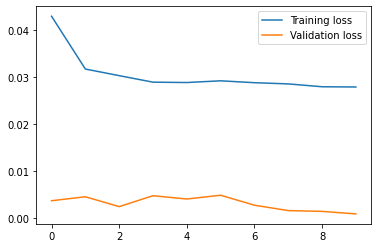

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [38]:
n_future=40  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

In [39]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


In [40]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [41]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original


/home/sjhyeon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Open
0,1970-05-11,0.694862
1,1970-05-12,0.692358
2,1970-05-13,0.684846
3,1970-05-14,0.666066
4,1970-05-15,0.657302
...,...,...
12860,2021-05-04,13.340000
12861,2021-05-05,13.160000
12862,2021-05-06,13.220000
12863,2021-05-07,13.160000


In [45]:
original = original.loc[original['Date'] >= '2021-03-01']

In [46]:
df_forecast

,Date,Open
0,2021-05-10,13.131593
1,2021-05-11,13.030827
2,2021-05-12,13.002004
3,2021-05-13,13.052686
4,2021-05-14,13.102947
5,2021-05-15,13.116059
6,2021-05-16,13.102419
7,2021-05-17,13.028805
8,2021-05-18,12.930682
9,2021-05-19,12.843681


/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='Open'>

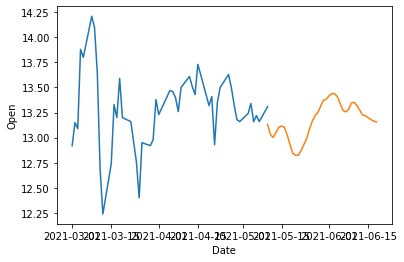

In [47]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])